# Part 1. Notebook for Network Analysis in Neuroscience

Authors: Eduarda Centeno & Fernando Santos

With notebook we would like to facilitate the computation of different metrics in network analysis in the field of Neuroscience. Our goal is to cover both standard Graph Theory metrics, and some 
Topological & Geometric Data Analysis metrics.

In here, we will not include any step regarding preprocessing of image data, but we assume that the connectivity matrix is already available. The matrices used here as examples are solely fMRI data (i.e., based in correlation values of time series) obtained from the [Human Connectome Project](http://umcd.humanconnectomeproject.org/umcd/default/browse_studies). However, the scripst used here can be easily adapted to networks based in other imaging modalities.

## Table of contents
1. [Imports](#requirements)
2. [Importing data & the connectivity matrix](#importing-data)
3. [Graph Theory](#graph-theory)
4. [Topology & Geometry](#TDA)

<a id='imports'></a>
###  **1.** Imports
#### Let's start with the necessary packages for the following computations: 

In [ ]:
# Basic data manipulation and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
%load_ext watermark

In [ ]:
# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark --packages jupyterlab,notebook

<a id='importing-data'></a>
### **2.** Importing data & the connectivity matrix
#### Now we will start working with the brain data. 
Here, we will try to cover both computation and some theoretical backgroud/key points on each section. 

##### Our first step will be on how to import the matrix data:

In [ ]:
matrix = np.genfromtxt('./1000_Functional_Connectomes/Connectivity matrices/AveragedMatrix.txt')

##################################################################################################
##### **Here I'll make available the computation on how to compute the avarege matrix, but to make it faster, we'll work with the file that we already saved.**
The idea here is to get an average matrix from all matrices available. For that, different methods can be used. We'll show two common ones: one with pandas, another with Numpy. 

In [ ]:
# Importing all matrices to generate averaged data with Numpy Or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv= np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix= MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

##################################################################################################

In [ ]:
# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('./1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('./subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('./subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('./subnet_colors_number.txt')

#### Now, let's use Seabon Heatmap to plot correlation matrix:
After importing the matrix that we want to work with, we can start with a stardad representation - heatmaps!

In [ ]:
# Creating a DataFrame with will have the brain areas as rows and column names for easier plotting of heatmap
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

##### Here is our Heatmap!

In [ ]:
# This mask variable gives you the possibility to plot only half of the correlation matrix.If you want the full version, alter parameter mask=None.
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None)

##### **Key point:**
When working with network analysis in brain data, a couple of key decisions have to be made in order to define how the metrics will be computed and how to best preseve information.
For example, one can decide to use all connections in the network - including ones with low values (sometimes considered as spurious connetions),  or it is possible to establish an arbitraty threshold of which connections will be kept (e.g. only connections above a correlation value of 0.8). This step can be done in different ways, based solely on the correlation threshold (as done here), but it can also be done based on network density (i.e. you keep only the 20% strongest correlations). 
If using an arbitraty threshold, it is also possible to define if the resulting matrix will be weighted (i.e. the value of each connection will be kept), or unweighted (binarized matrices).

Another point of discussion is how to deal with negative weights in weighted networks. Several metrics from graph theory are not adapted for negative weights, therefore a common practice is to absolutize the matrix, therefore preserving the topology but sending all weights to positive values. 
Here, we have chosen to proceed by using all connections in the correlation matrix, and absolutize them so that all metrics can be computed.

*We strongly suggest the readers to read Reference [1] for a deeper understanding on all these decisions.*

A summary of the types of networks can be found below:

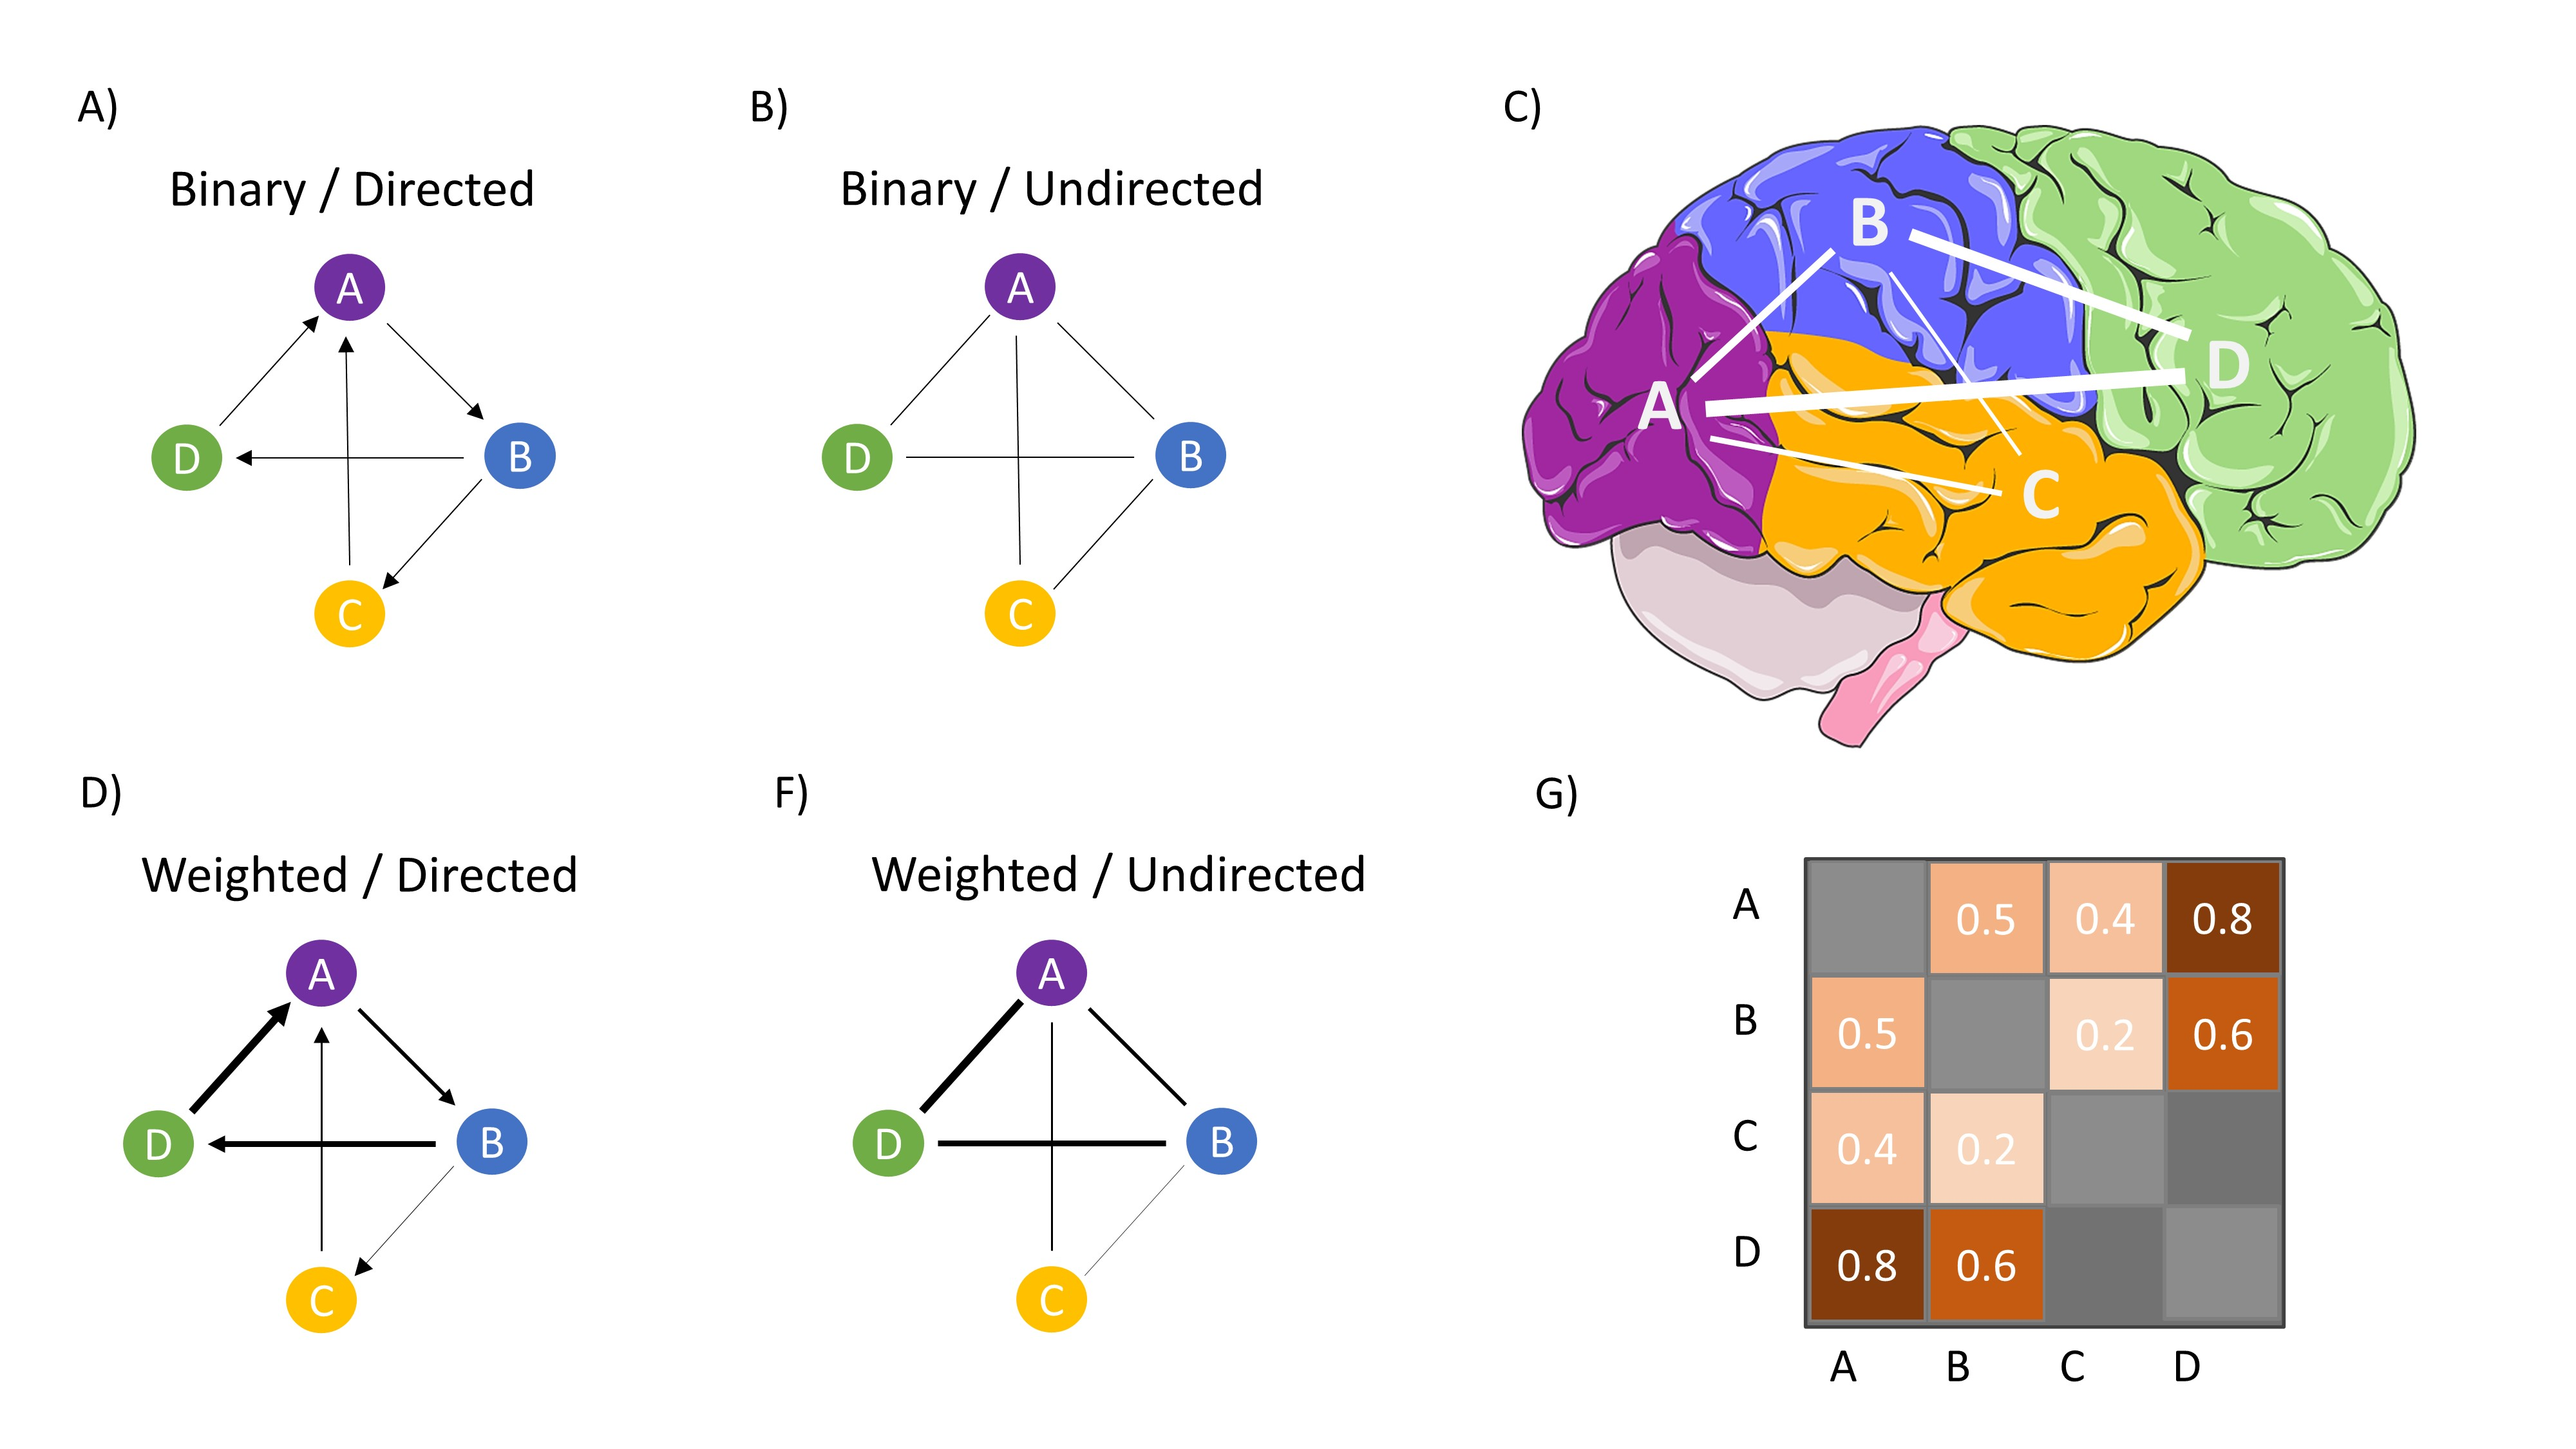

Figure 1. Types of networks. A) A binary directed graph. B) Binary, undirected graph.  C) A representation of the graph F in the context of brain areas. D) A weighted, directed graph. F) A weighted, undirected graph. G) A connectivity matrix of C and F. Source: Part of the image was obtained from [Smart Servier Medical Art](https://smart.servier.com/).

In [ ]:
# Absolutize for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

##### **Key point:**
When working with network data, there are some interesting basic computations that can tell us basic properties about it. When working with undirected weighted matrices, for example, the distribution of strenght values can tell us about how many weak correlations we might have. In general, in fMRI correlation data we expect most to be weak correlations and a few strong ones. When plotted as a probability density of log10, we expect it to be close to a Gaussian distribution!

In [ ]:
# Weight distribution plot
bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matrixdiagNaN.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(matrixdiagNaN).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

<a id='graph-theory'></a>
### **3.**  Graph Theory 
#### From now, we will start working with some common Graph Theory metrics.
The metrics that we will cover here are:
- Density
- Degree/Strength -  *the term degree is commonly used for binary graphs whereas strength tends to be used for weighted networks. (Ref [1] - Chapter 4)*
- Centrality: Eigenvector, Betweenness, Closeness, Degree, Page Rank
- Path length
- Modularity
- Assortativity
- Clustering coefficient

##### **Key point:**
Each of these metrics have their own requisites for computation. For example, metrics such as closeness centrality and  average shortest path cannot be computed accurately for fragmented networks (i.e. there are subsets of disconnected nodes). Therefore, when thinking about establishing arbitrary thresholds for the matrix, this must be taken into account.

A summary of some metrics can be found in the figure below:

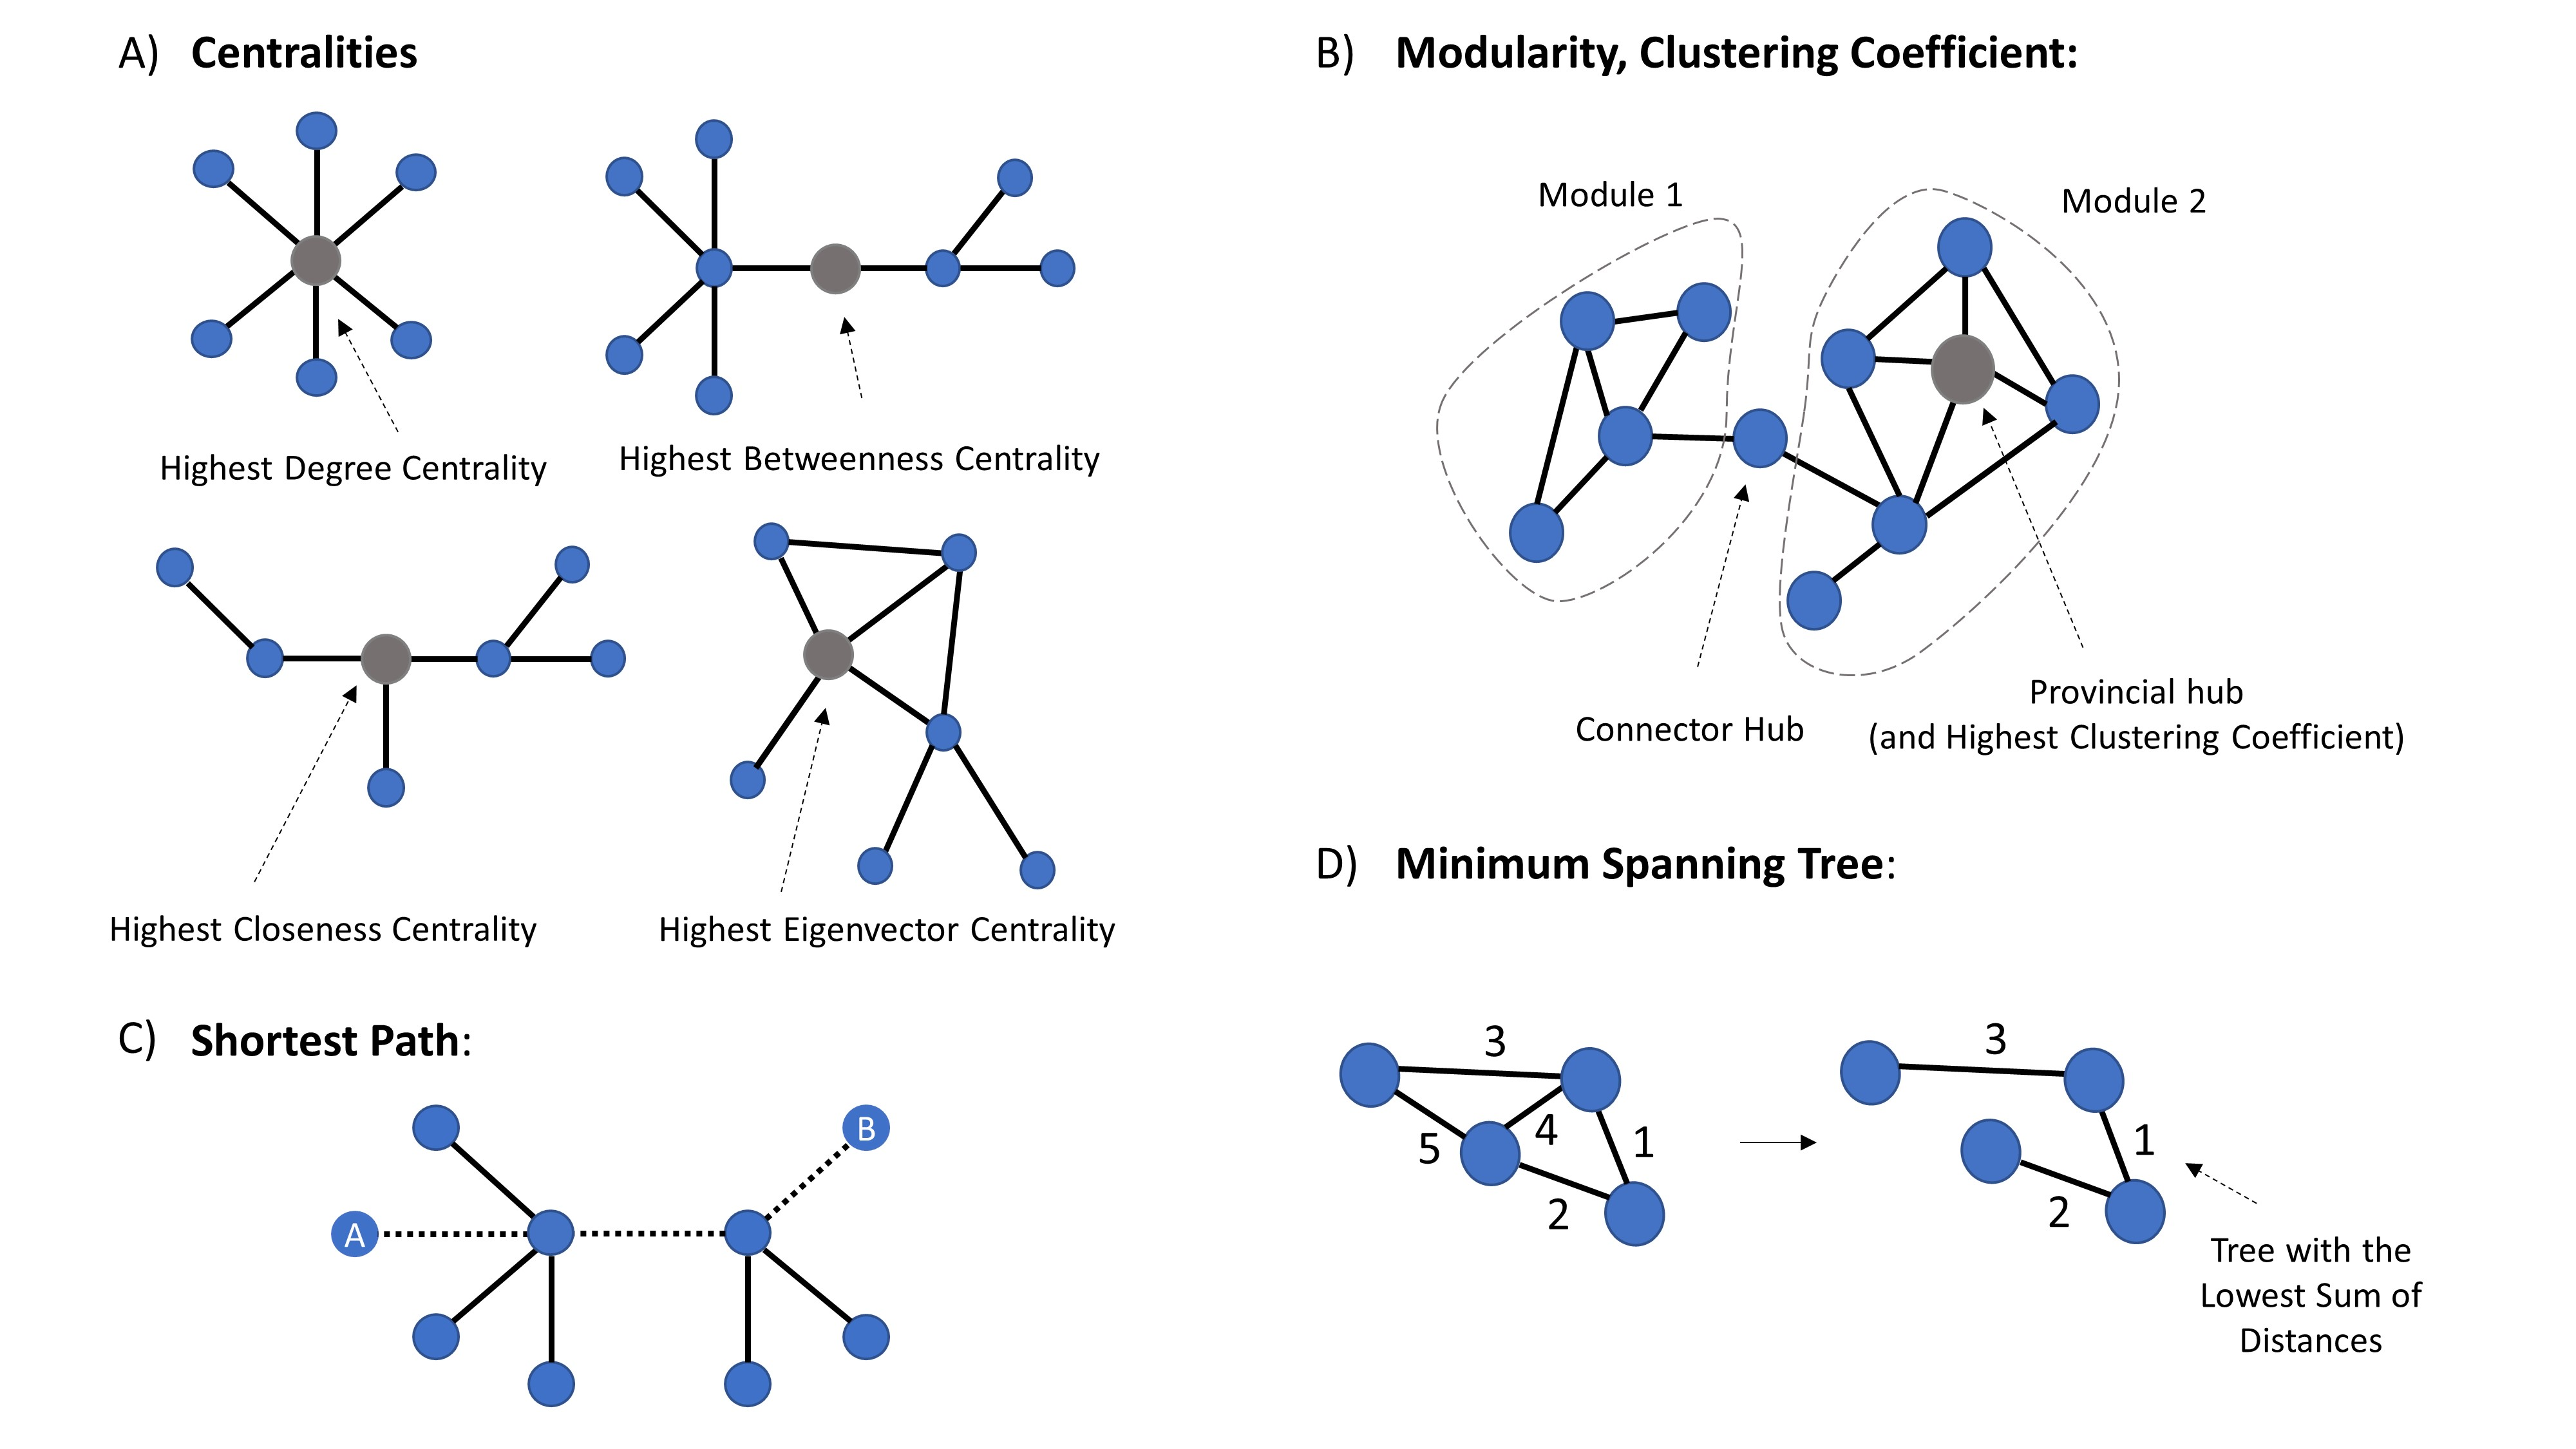
Figure 2. Graph theoretical metrics. A) A representation of a graph indicating centralities. B) Two modules connected to each other via a  connector hub. A provincial hub can be identified in grey (which in this case also has the highest clustering coefficient).  C) The shortest path between nodes A and B. D) The minimum spanning tree.

##### We will start by creating the graph and removing its self-loops (i.e. a connection of a node with itself).

In [ ]:
# Creating Graph
G = nx.from_numpy_matrix(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

##### Now, we compute the density of the network - another key basic information that is usually obtained for graphs.


<u>Definition</u>:
 The density of a graph is the ratio between the number of edges and the total number of possible edges. 

Clearly, in all-to-all connected graphs, the density will be maximal (1), whereas for a graph withouth edges it will be 0. Here, just for the sake of demonstration, we will compute the density of different states of the network to show how density changes.

In [ ]:
#print(nx.density.__doc__)

# Create graphs from comparison
matrix2 = matrix.copy()
matrix3 = matrix.copy()

# Create sparser graphs
matrix2[matrix2<=0.50] = 0
matrix3[matrix3<=0.75] = 0

st50G = nx.from_numpy_matrix(matrix2)
st25G = nx.from_numpy_matrix(matrix3)

st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))

# Compute densities
alltoall = nx.density(G)
st50 = nx.density(st50G)
st25 = nx.density(st25G)

names = ['All-To-All', '> 0.5', '> 0.75']
values = [alltoall, st50, st25]

dict(zip(names, values))

##### Now, we compute the degree/strength of the nodes.

<u>Definition</u>: In undirected weighted networks the node strength can be computed as the sum of the connectivity weights of the edges attached to each node. It is a basic metric to identify how important is a node in the graph. 
To make this value more intuitive, it is possible to normalize it by diving the sum of the weights by 1/N-1. (Ref [1] pg. 119)  

In degree computation, it is also common to compute the mean degree of the network, which is the sum of node degrees divides by the total number of nodes.

In [ ]:
# Computation of graph degree and add as attribute
#print(nx.degree.__doc__)

strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, dict(strength), 'strength')

# Normalized node strenght values 1/N-1
normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrenghts, 'strengthnorm')

# Computing the mean degree of the network
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print(mean_degree)

##### Next, we will compute the centralities!

Centralities are frequently used to understand which nodes occupy critical positions in the network.

Remember: 
- Degree Centrality: The degree centrality for a node **v** is the fraction of nodes it is connected to. This is the same as node degree, so it will not be computed again. (NetworkX Documentation)

- Closeness Centrality: In weighted graphs, the closeness centrality of a node __v__ is the reciprocal of the sum of the shortest weighted path distances from **v** to all *N-1* other nodes. An important thing to think about this metric is that it is possible for a node with many low weight edges to have the same centrality as a node with only a few high-weighted edges. (NetworkX Documentation, Ref [1] - Chapter 5)

- Betweenness Centrality: Betweenness centrality of a node **v** is the sum of the fraction of all-pairs shortest paths that pass through __v__. (NetworkX Documentation) 

- Eingenvector Centrality: Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. It takes into account not only quantity (e.g. degree centrality), but also quality. If a node is linked to many nodes that also display a high degree, then that node will have high eigenvector centrality. (NetworkX Documentation)

- Page Rank: PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. (NetworkX Documentationn)

In [ ]:
# Closeness centrality
#print(nx.closeness_centrality.__doc__)

# This function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# ... of the weight value. Thus, a high correlation value (e.g. 0.8) means a shorter distance (i.e 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Computation of Closeness Centrality
closeness = nx.closeness_centrality(G, distance='distance')

# Now we add the closeness centrality value as an attribute to the nodes
nx.set_node_attributes(G, closeness, 'closecent')

# Visualize values directly
#print(closeness)

# Closeness Centrality Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Betweenness centrality:
#print(nx.betweenness_centrality.__doc__)
betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True) 
                                                                
# Now we add the it as an attribute to the nodes
#nx.set_node_attributes(G, betweenness, 'bc')

# Visualize values directly
#print(betweenness)

# Betweenness centrality Histogram
sns.distplot(list(betweenness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Eigenvector centrality
#print(nx.eigenvector_centrality.__doc__)
eigen = nx.eigenvector_centrality(G, weight='weight')

# Now we add the it as an attribute to the nodes
nx.set_node_attributes(G, eigen, 'eigen')

# Visualize values directly
#print(eigen)

# Eigenvector centrality Histogram
sns.distplot(list(eigen.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Page Rank
#print(nx.pagerank.__doc__)
pagerank = nx.pagerank(G, weight='weight')

# Add as attribute to nodes
nx.set_node_attributes(G, pagerank, 'pg')

# Visualize values directly
#print(pagerank)

# Page Rank Histogram
sns.distplot(list(pagerank.values()), kde=False, norm_hist=False)
plt.xlabel('Pagerank Values')
plt.ylabel('Counts')

##### Now, let's move on to the Path Length!

- Shortest Path:  The shortest path (or distance) between two nodes in a graph. In a weighted graph it is obtained by the minimum sum of weights.

- Average Path Length: It is a concept in network topology that is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. It is a measure of the efficiency of information or mass transport on a network.

In [ ]:
# Path Length
#print(nx.shortest_path_length.__doc__)

# This is a versatile version of the ones below in which one can define or not source and target. Remove the hashtag to use this version.
#list(nx.shortest_path_length(G, weight='distance'))

# This one can also be used if defining source and target: 
#print(nx.dijkstra_path_length.__doc__)
nx.dijkstra_path_length(G, source=20, target=25, weight='distance')

# Whereas this one is for all pairs. Remove the hashtag to use this version.
#print(nx.all_pairs_dijkstra_path_length.__doc__)
#list(nx.all_pairs_dijkstra_path_length(G, weight='distance'))

In [ ]:
# Average Path Length or Characteristic Path Length
#print(nx.average_shortest_path_length.__doc__)
nx.average_shortest_path_length(G, weight='distance')

##### Now, modularity, assortativity, clustering coefficient and the minimum spanning tree!

- Modularity: Modularity compares the number of edges inside a cluster with the expected number of edges that one would find if the network was connected randomly but with the same number of nodes and node degrees. It is used to identify strongly connected subsets, i.e. modules or 'communities'. Here, we will use the Louvain algorithm as recommended in page Ref [1].

- Assortativity: Assortativity measures the similarity of connections in the graph with respect to the node degree. (NetworkX)

- Clustering coefficient: a measure of the tendecy for any two neighbors of a node to be directly connected to each other. According to Networkx's documentation, the clustering coefficient for weighted graphs is defined as the geometric average of the subgraph edge weights. (NetworkX, Ref [1])

- Minimum Spanning Tree: it is the backbone of a network, i.e. the minimum set of edges necessary to ensure that paths exist between all nodes. There are a few main algorithms used to build the spanning tree, being the Kruskal’s algorithm the one used by NetworkX. Briefly, this algorithm ranks the distance of the edges, adds the ones with the smallest distance first, and by adding edge by edge it checks if cycles are formed or not. The algorithm will not add an edge that results in the formation of a cycle. 

In [ ]:
# Modularity
#print(community.best_partition.__doc__)
#from community import best_partition
part = community.best_partition(G, weight='weight')

# Visualize values directly
#print(part)

# Visualize number of communities
set(part.values()).union()

In [ ]:
# Assortativity
#print(nx.degree_pearson_correlation_coefficient.__doc__)
nx.degree_pearson_correlation_coefficient(G, weight='weight')

In [ ]:
# Clustering Coefficient
#print(nx.clustering.__doc__)
clustering = nx.clustering(G, weight='weight')

# Add as attribute to nodes
nx.set_node_attributes(G, clustering, 'cc')

# Visualize values directly
#print(clustering)

# Clustering Coefficient Histogram
sns.distplot(list(clustering.values()), kde=False, norm_hist=False)
plt.xlabel('Clustering Coefficient Values')
plt.ylabel('Counts')

In [ ]:
# Average Clustering Coefficient
#print(nx.clustering.__doc__)
nx.average_clustering(G, weight='weight')

In [ ]:
# Minimum Spanning Tree
GMST = nx.minimum_spanning_tree(G, weight='distance')

#### Data Visualization & Graph Theory
Under this section we we'll provide a few ideas of how to visualize and present your network.

First, let's get some important attributes about brain area names and subnetworks. These will be used later for graphical visualization!

In [ ]:
# Function to transform our list of brain areas into a dictionary
def Convert(lst): 
    res_dct = {i : lst[i] for i in range(0, len(lst))} 
    return res_dct

# Add brain areas as attribute of nodes
nx.set_node_attributes(G, Convert(lineList), 'area')

# Add node colors
nx.set_node_attributes(G, Convert(colorlist), 'color')

# Add subnetwork attribute
nx.set_node_attributes(G, Convert(sublist), 'subnet')

# Add node color numbers
nx.set_node_attributes(G, Convert(colornumbs), 'colornumb')

Now we will create a standard spring network plot, but this could also be made circular by changing to *draw_circular*.

We defined the edge widths to the power of 2 so that weak weights will have smaller widths.

In [ ]:
# Standard Network graph with nodes in proportion to Graph degrees
plt.figure(figsize=(30,30))
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=True, width=np.power(edgewidth, 2), edge_color='grey', node_size=normstrengthlist*20000, 
        labels=Convert(lineList), font_color='black', node_color=colornumbs/10, cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
#plt.savefig('network.jpeg')

In [ ]:
# Let's visualize the Minimum Spanning Tree
plt.figure(figsize=(15,15))
nx.draw(GMST, with_labels=True, alpha=0.7, font_size=9)

* Detail! 
For the sake of making the visualization less overwhelming, we will work with the st50G for the CircosPlot.

In [ ]:
# First let's just add some attributes so it becomes more interesting

nx.set_node_attributes(st50G, dict(st50G.degree(weight='weight')), 'strength')

nx.set_node_attributes(st50G, Convert(lineList), 'area')

nx.set_node_attributes(st50G, Convert(colorlist), 'color')

nx.set_node_attributes(st50G, Convert(sublist), 'subnet')

#edgecolors = {(e1, e2): int((weight+1)**3) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
#nx.set_edge_attributes(st50G, edgecolors, 'edgecolor')

G_distance_dict2 = {(e1, e2): 1 / abs(weight) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, G_distance_dict2, 'distance')


st50GRL = nx.relabel_nodes(st50G, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(st50GRL, figsize=(30,30), node_labels=True, node_label_layout='rotation', node_order='subnet',
                  edge_color='weight', edge_width='weight', node_color='subnet', node_label_color=True, fontsize=10, 
                  nodeprops={"radius": 2}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = sorted(list(set([list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))])))

plt.legend(handles=circ.legend_handles,
           title="Subnetwork",
           ncol=6,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= labels_networks)

plt.show()

In [ ]:
# How to get node positions according to https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [ ]:
# Visualization of Communities/Modularity - Run cells 135 and 137 before!
plt.figure(figsize=(25,25))
values = [part.get(node) for node in G.nodes()]
clust=[i*9000 for i in nx.clustering(G, weight='weight').values()]
nx.draw(G, pos=community_layout(G, part), font_size=8, node_size=clust, node_color=values, width=np.power([ d['weight'] for (u,v,d) in G.edges(data=True)],2), 
        with_labels=True, labels=Convert(lineList), font_color='black', edge_color='grey', cmap=plt.cm.Spectral, alpha=0.7)

<a id='TDA'></a>

## **4.** Topology & Geometry
#### Moving on to Topology & Geometry metrics.

Here, we will cover a few computations that are being applied in Neuroscience:
- Persistent Homology
- Euler Characteristic and Curvature

#####  Let's start with persistent homology computations: 
Persistent homology is a method for computing topological features of a space at different spatial resolutions. 
With it we can track homology cycles across simplicial complexes, and determine whether there were homology classes that “persisted” for a long time (Ref [2]).
The basic idea is summarized in the illustration below.

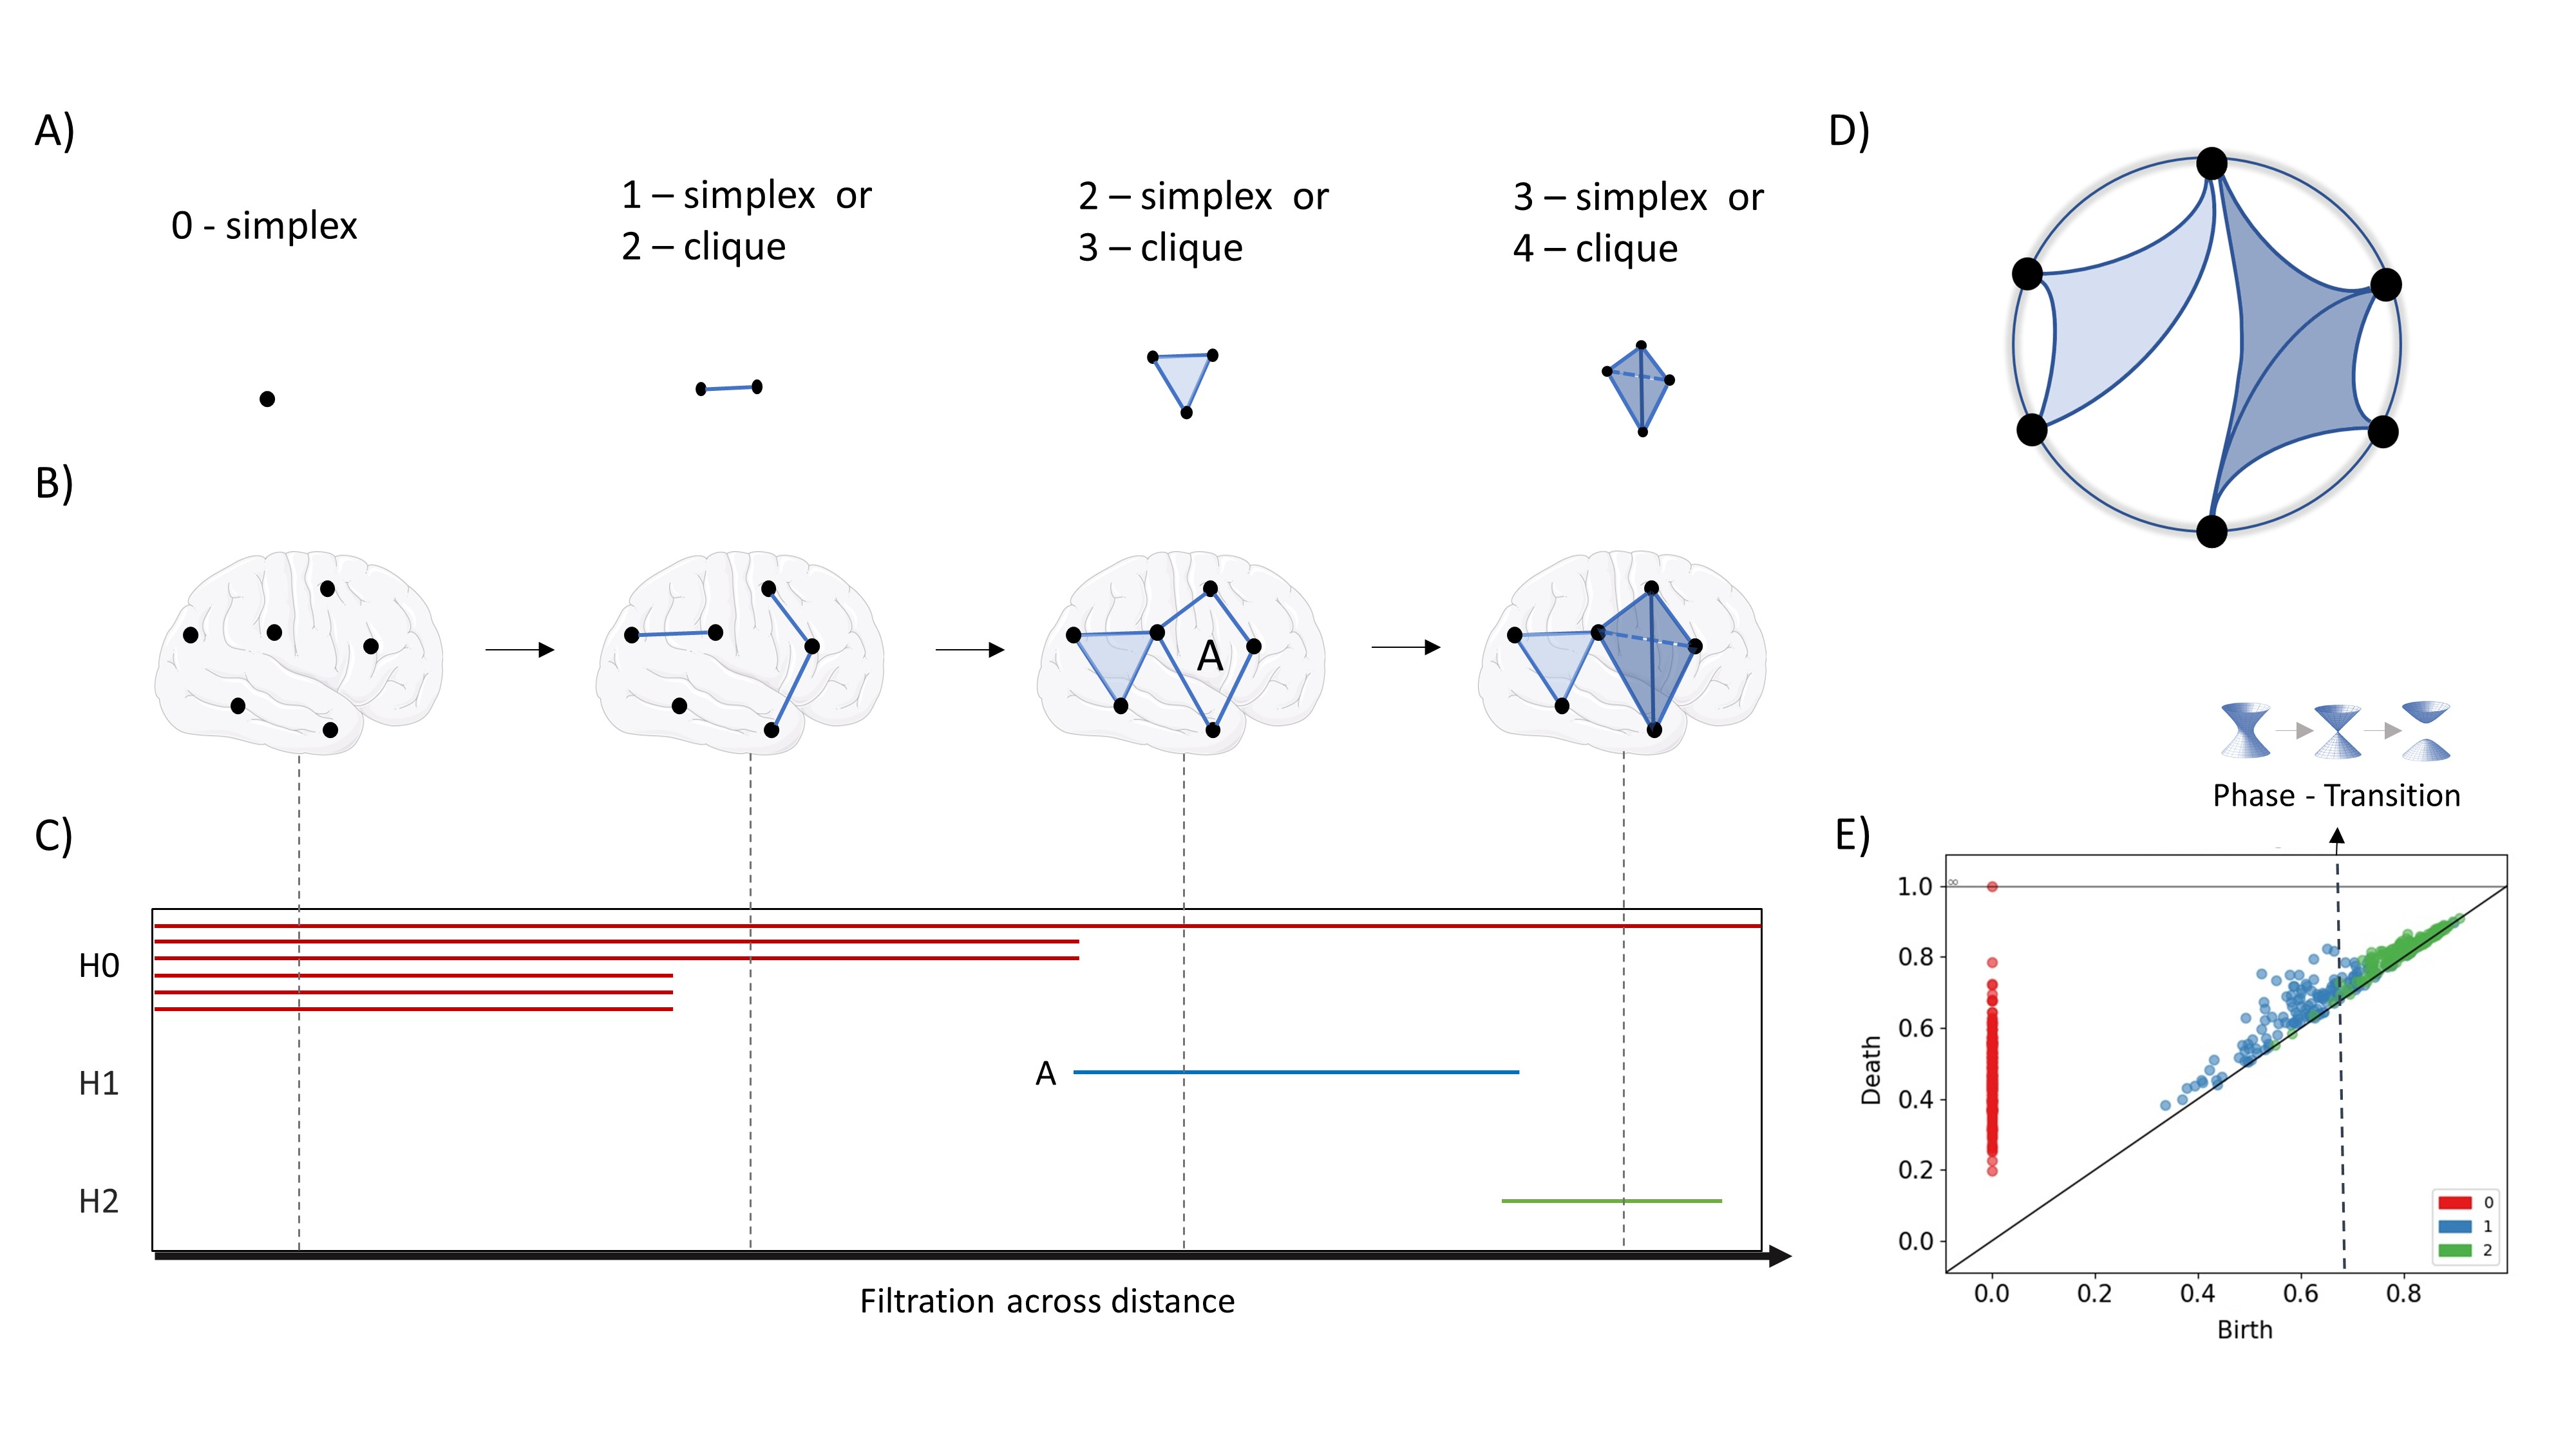
A) Types of simplices and cliques. B) Evolution of shapes across filtration. C) Persistence Barcode D) What it would represent in how the brain is connected. E) Birth-Death graphs from C. Phase-transitions can be identified in this plot. 

In [ ]:
# Computation of persistence barcode  (http://gudhi.gforge.inria.fr/python/latest/persistence_graphical_tools_user.html)

# Converting to correct distance matrix
mattop = 1 - matrix

# Computing and plotting barcode
rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)
#plt.savefig('barcode.jpeg')

In [ ]:
# Persistence Diagram 
gudhi.plot_persistence_diagram(diag, legend=True, max_intervals=0)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Death', fontsize=15)
#plt.savefig('persdiagram.jpeg')

In [ ]:
# Persistency density plots
gudhi.plot_persistence_density(diag, dimension=1)
#plt.savefig('persdensityDim1.jpeg')

#####  Computation of phase transitions and curvature

One way of connecting geometry of a continuous surface to its topology is by using the concept of local curvature and Euler characteristic. Here, we will compute the network curvature at each node to calculate tolopogical phase transitions in brain networks from a local perspective (Ref [3])

In [ ]:
%run "./Background Scripts/Curvature.py"

In [ ]:
# Euler entropy Sχ = ln |χ| as a function of the correlation threshold level ε of functional brain networks from the HCP data set.
plotEuler(matrix,70,0)

#####  Now, we can obtain the value of curvature for each node at a specific threshold, and then save as a dict with the region name abbreviations.

In [ ]:
# Obtaining the value of curvature for each node at a specific threshold and creating a dictionary with region names.
curvvalues = Curv(0.6, matrix)
dict(zip(lineList, curvvalues))

In [ ]:
# Histogram for curvature distribution at a specific threshold.
curv_values= Curv(0.6, matrix)
sns.distplot(curv_values, kde=False, norm_hist=False)
plt.xlabel('Curvature Values')
plt.ylabel('Counts')

##### References

[1] Fornito A, Zalesky A, Bullmore E (2016) Fundamentals of brain network analysis: Academic Press.

[2] Bassett DS, Sporns O (2017) Network neuroscience. Nature neuroscience 20:353.

[3] Santos FAN, Raposo EP, Coutinho-Filho MD, Copelli M, Stam CJ, Douw L (2019) Topological phase transitions in functional brain networks. Phys Rev E 100:032414.


##### Acknowledgements

"Data were provided [in part] by the Human Connectome Project, MGH-USC Consortium (Principal Investigators: Bruce R. Rosen, Arthur W. Toga and Van Wedeen; U01MH093765) funded by the NIH Blueprint Initiative for Neuroscience Research grant; the National Institutes of Health grant P41EB015896; and the Instrumentation Grants S10RR023043, 1S10RR023401, 1S10RR019307."